In [1]:
import gensim
from nltk.corpus import stopwords
from textblob import Word
import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score,roc_curve


In [3]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [4]:
train=pd.read_csv('train_2kmZucJ.csv')
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
test=pd.read_csv('test_oJQbWVk.csv')
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [6]:
df=train.append(test,ignore_index=True)
df.head()

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [7]:
stop=stopwords.words('english') 
def preprocess(tweet):
    final_text=' '
    #tokenization using gensim
    tokens=gensim.utils.simple_preprocess(str(tweet),deacc=True)
    #text normalization using textblob
    lemmed_tokens=[Word(i.lower(),pos_tag='v')for i in tokens if i.lower() not in stop]
    final_text=final_text.join(lemmed_tokens)
    return final_text
    
    
    
        
        
    
    
    
    
    
    
    

In [8]:
df['clean_tweet']=df['tweet'].apply(lambda x :preprocess(x))
df.head()

,id,label,tweet,clean_tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test https goo gl mfqv a...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle ...
2,3,0.0,We love this! Would you go? #talk #makememorie...,love would go talk makememories unplug relax i...
3,4,0.0,I'm wired I know I'm George I was made that wa...,wired know george made way iphone cute daventr...
4,5,1.0,What amazing service! Apple won't even talk to...,amazing service apple even talk question unles...


In [9]:
from gensim.models import Word2Vec

In [10]:
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = Word2Vec(tokenized_tweet, size=500,  window=10)

model_w2v.train(tokenized_tweet, total_examples= len(df['clean_tweet']), epochs=20)

(1747413, 2862340)

In [11]:
model_w2v.wv.most_similar(positive="love")

[('valentineday', 0.6397615671157837),
 ('daughter', 0.6360577344894409),
 ('special', 0.6198958158493042),
 ('poem', 0.6190009713172913),
 ('valentineapp', 0.6027131080627441),
 ('icons', 0.5995475053787231),
 ('romance', 0.5905157923698425),
 ('forever', 0.586988627910614),
 ('nowplaying', 0.586227536201477),
 ('idol', 0.5856589078903198)]

In [12]:
len(model_w2v['company'])

500

In [13]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [15]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 500))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 500)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9873, 500)

In [16]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.125227,-0.391683,0.131354,0.091585,-0.438580,-0.375053,0.162052,0.169032,-0.407086,-0.141479,...,-0.063897,0.360795,-0.406531,0.062980,-0.268502,-0.204521,-0.119259,-0.001938,0.182977,-0.051623
1,0.086305,-0.253614,-0.000789,0.041753,-0.215913,-0.110257,-0.360805,-0.202722,-0.056936,0.073522,...,0.193842,-0.000568,0.225405,-0.060997,0.243380,0.217117,0.183296,-0.034310,0.328386,0.047577
2,-0.082121,-0.102895,0.027893,0.077724,-0.203670,-0.113614,0.174711,0.017546,-0.285995,0.023068,...,0.025538,0.110715,-0.071643,0.141493,0.021824,-0.003089,-0.123384,-0.012902,0.119232,-0.089292
3,0.085471,-0.411108,0.094894,0.212668,-0.290226,-0.166844,0.027329,-0.048807,-0.068764,-0.038895,...,0.059906,0.277203,-0.055383,-0.022271,0.093931,-0.180991,-0.077809,-0.033997,0.173783,-0.107399
4,-0.230748,-0.119309,-0.077226,-0.131885,-0.261942,0.033899,0.324270,0.209370,-0.296897,0.197245,...,-0.059451,0.143881,-0.106591,0.390951,0.011605,0.039551,-0.150310,0.122150,-0.085752,-0.245766


In [17]:
print(train.shape)
print(test.shape)
train_df=wordvec_df.iloc[:7920,:]
test_df=wordvec_df.iloc[7920:,:]

(7920, 3)
(1953, 2)


In [18]:
print(train_df.shape)
print(test_df.shape)

(7920, 500)
(1953, 500)


In [19]:
label=train['label']

In [20]:
x_train,x_test,y_train,y_test=train_test_split(train_df,label,test_size=.2,random_state=42)


In [21]:
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)
gbc_pre=gbc.predict(x_test)
print(f1_score(y_test,gbc_pre,average='weighted'))

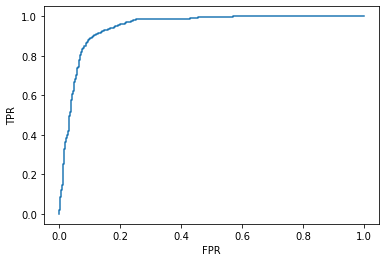

In [23]:
import matplotlib.pyplot as plt
prob=gbc.predict_proba(x_test)[::,1]
fpr,tpr,threshold=roc_curve(y_test,prob)
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.plot(fpr,tpr)


In [38]:
#tuning=pd.DataFrame({'FPR':fpr,'TPR':tpr,"THRESHOLD":threshold})
tuning[tuning['TPR']>.80][20:40]


,FPR,TPR,THRESHOLD
152,0.081597,0.851852,0.402416
153,0.085938,0.851852,0.391631
154,0.085938,0.858796,0.378440
155,0.087674,0.858796,0.373135
156,0.087674,0.861111,0.369666
157,0.088542,0.861111,0.368042
158,0.088542,0.865741,0.363588
159,0.090278,0.865741,0.352516
160,0.090278,0.868056,0.350901
161,0.092014,0.868056,0.338156


In [39]:

new_pred=[]
    
for i in prob:
    if i >0.305875:
        new_pred.append(1)
    elif i<0.305875:
        new_pred.append(0)
    

In [40]:
print(f1_score(y_test,new_pred,average='weighted'))

0.8990897370032458


In [41]:
test_df_pre=gbc.predict(test_df)

In [45]:
submisssion=pd.DataFrame({'id':test["id"],'label':test_df_pre})


In [46]:
submisssion.to_csv(r'submission_tweets_w2v_without_tune.csv', index = False)